In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from scipy.stats import probplot, yeojohnson
import pmdarima as pm
from arch import arch_model

## Load SMI data

Data source: https://data.snb.ch/de/topics/finma/cube/capchstocki?fromDate=2020-01-01&toDate=2024-12-22

In [2]:
raw = pd.read_csv("data/snb-data-pivoted-all-20241121_0900.csv", parse_dates=["Date"], index_col="Date")

In [3]:
raw.index = raw.index.to_period('D')

## Clean & normalize data

In [4]:
index_clean = raw["Gesamtindex"].dropna()
index_daily = index_clean.div(index_clean.iloc[0]).mul(100)

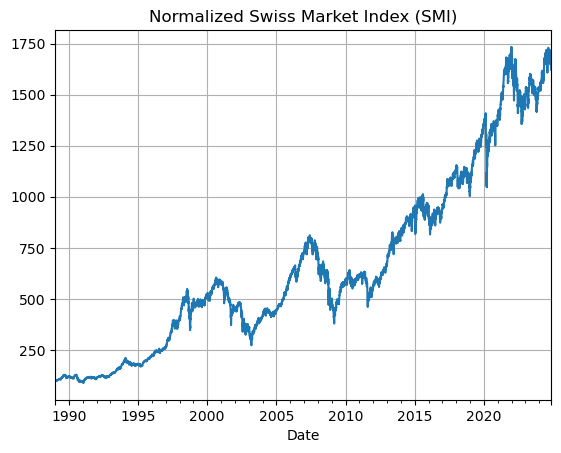

In [10]:
index_daily.plot(grid=True, title="Normalized Swiss Market Index (SMI)")
plt.show()

In [44]:
def find_trend(data, deg):
    x = np.array(range(len(data)))
    params = np.polyfit(x, data, deg=deg)
    tr = np.zeros(len(x))
    for exp, par in enumerate(params[::-1]):
        tr += par*x**exp
        
    return tr

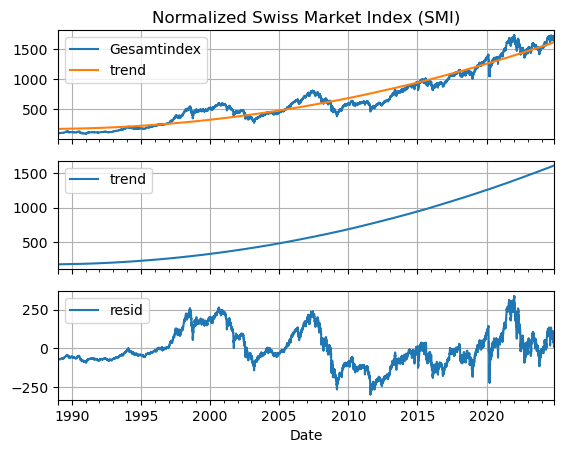

In [79]:
x = np.array(range(len(index_daily.values)))

index_daily["trend"] = find_trend(index_daily["Gesamtindex"], 2)
index_daily["resid"] = index_daily["Gesamtindex"] - index_daily["trend"]

fig, axs = plt.subplots(3,1, sharex=True)
ax = axs[0]
index_daily.plot(y = "Gesamtindex", title="Normalized Swiss Market Index (SMI)", ax=ax)
index_daily.plot(y = "trend", grid=True, ax=ax)

ax = axs[1]
index_daily.plot(y = "trend", grid=True, ax=ax)

ax = axs[2]
index_daily.plot(y = "resid", grid=True, ax=ax)
plt.show()

In [76]:
am = arch_model(index_daily["resid"], vol='ARCH', p=1)

In [77]:
fit = am.fit()
print(fit.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 90928.35422744235
Iteration:      2,   Func. Count:     10,   Neg. LLF: 65501.303473790016
Iteration:      3,   Func. Count:     16,   Neg. LLF: 92468.70152963216
Iteration:      4,   Func. Count:     21,   Neg. LLF: 50732.27598663336
Iteration:      5,   Func. Count:     26,   Neg. LLF: 50661.09580858635
Iteration:      6,   Func. Count:     30,   Neg. LLF: 50660.027557196045
Iteration:      7,   Func. Count:     34,   Neg. LLF: 50653.48008824586
Iteration:      8,   Func. Count:     38,   Neg. LLF: 50617.485944397115
Iteration:      9,   Func. Count:     42,   Neg. LLF: 50413.70302405859
Iteration:     10,   Func. Count:     46,   Neg. LLF: 70836.5121794166
Iteration:     11,   Func. Count:     51,   Neg. LLF: 73520.24253626986
Iteration:     12,   Func. Count:     56,   Neg. LLF: 81493.0663808088
Iteration:     13,   Func. Count:     61,   Neg. LLF: 67534.5223131612
Iteration:     14,   Func. Count:     66,   Neg. LLF: 68948.7776

/usr/local/Caskroom/miniconda/base/envs/timeseries/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.297e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [70]:
results = pm.auto_arima(index_daily["resid"].to_timestamp().resample('QE').first())

In [71]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -777.039
Date:                Mon, 30 Dec 2024   AIC                           1558.078
Time:                        01:34:17   BIC                           1564.017
Sample:                    03-31-1989   HQIC                          1560.491
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8813      0.032     27.336      0.000       0.818       0.945
sigma2      2818.2477    240.730     11.707      0.000    2346.426    3290.070
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                29.10
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               3.59   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

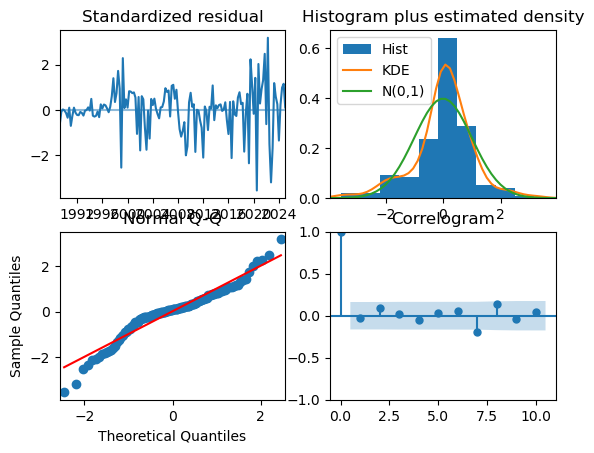

In [72]:
results.plot_diagnostics()
plt.show()

In [ ]:
quarterly_df = index_daily[(index_daily.index.month==1) & (index_daily.index.day == 3)]
quarterly_df.plot(grid=True, title="Normalized Swiss Market Index (SMI)")
plt.show()

In [ ]:
weekly_data = index_daily.to_timestamp().resample('W').first()

In [ ]:
first_data_per_year.plot(grid=True)
plt.show()

In [ ]:
decomposition = sm.tsa.seasonal_decompose(index_daily.to_timestamp().resample('ME').first())

In [ ]:
sm.tsa.seasonal_decompose(index_daily.to_timestamp().resample('W').first()).plot()
plt.show()

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(8,6))
for i, period in enumerate([1, 30, 90, 182, 365]):
    print(f"Period = {period} days")
    index = index_daily.rolling(period).mean().dropna()

    # Check stationarity
    adf = adfuller(index.pct_change().dropna())
    print(f"Statistic: {adf[0]}")
    print(f"p-value: {adf[1]}")

    # Compute percentage change
    pch = index.pct_change().dropna()

    # Compute outlier fraction
    q25 = pch.quantile(0.25)
    q75 = pch.quantile(0.75)
    outl_mask = (pch<1.5*q25) | (pch>1.5*q75)
    print(f"Fraction of outliers: {100*np.round(sum(outl_mask)/len(outl_mask),4)}%")
    print()
    
    # Check Gaussianity
    probplot(pch, plot=axs[i//2,i%2])
    axs[i//2,i%2].set_title(f"Rolling window = {period} days") 
    axs[i//2,i%2].grid(True)
axs[2,1].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
index_semiy = index_daily.rolling(182).mean().dropna()
pch_semiy = index_semiy.pct_change().dropna()

In [ ]:
results = pm.auto_arima(index_daily.to_timestamp().resample('W').first(), seasonal=True, stepwise=True, trend='auto')
results.bic()

In [ ]:
results.get_params()

In [ ]:
results.plot_diagnostics()
plt.show()

## Make time series stationary for further analysis

We find, that the percentage changes of the normalized SMI time series is stationary.

In [ ]:
stat_ts = pch_semiy.dropna()

In [ ]:
stat_ts.info()

In [ ]:
ser, lmda = yeojohnson(stat_ts)#.apply(lambda x: np.log(x+0.002)).diff(365).diff(365).dropna()

In [ ]:
ser_trf=pd.Series(ser, index=stat_ts.index)
ser_trf

In [ ]:
fig, ax = plt.subplots()
stat_ts.plot(title="Percentage change of SMI", c="b", ax=ax)
ser_trf.plot(grid=True, ax=ax, ls=":", c="orange")
ax.axhline(y=ser.mean(), c="b", ls="-", lw=2)
ax.axhline(y=ser_trf.mean(), c="orange", ls="--", lw=2)
plt.show()

In [ ]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(10,4),gridspec_kw={'height_ratios':[1,3]})
ax = axs[0]
df = pd.concat([stat_ts, ser_trf], axis=1)
df.rename(columns={"Gesamtindex": "original", 0: "yeo-johnson trafo"}, inplace=True)
df.plot(kind="box", vert=False, ax=ax, grid=True)
ax = axs[1]
stat_ts.plot(kind="hist", bins=50, grid=True, facecolor="blue", ax=ax, alpha=0.5, label="original")
ser_trf.plot(kind="hist", bins=50, grid=True, facecolor="orange", ax=ax, alpha=0.5, label="yeo-johnson trafo")
ax.legend(loc="best")
plt.show()

The visualization above shows that the original and the Yeo-Johnson transformed data exhibit very similar characteristics: both have quite heavy tails and are strictly speaking bi-modal. Therefore, we concluse that the Yeo-Johnson transformation does not transform the original data into a normal distribution enough to be satisfactory. As a result, we shall continue with the original, untransformed data.

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax = axs[0]
plot_acf(stat_ts.dropna(), lags=[1]+[10*i for i in range(1,55)], zero=False, ax=ax)
ax.set_ylim([-0.3, 1.1])
ax.grid(True)

ax = axs[1]
plot_pacf(stat_ts.dropna(), lags=[1]+[10*i for i in range(1,55)]+[183, 365, 547], zero=False, ax=ax)
ax.set_ylim([-0.1, 1.1])
ax.grid(True)
plt.show()

From the above (partial) autocorrelation plots we can deduce the following two insights:

1) The time series in stats_ts closely resembles an AR(1) model
2) There is still some periodicity in the data which we'll need to eliminate

## Find best ARIMA model

In [ ]:
meas = {"p": [], "q": [], "AIC": [], "BIC": []}

for p in range(5):
    for q in range(5):
        print(p,0,q)
        meas["p"].append(p)
        #meas["d"].append(d)
        meas["q"].append(q)
        model = ARIMA(stat_ts, order=(p,0,q))

        try:
            res=model.fit()
            meas["AIC"].append(res.aic)
            meas["BIC"].append(res.bic)
        except:
            meas["AIC"].append(None)
            meas["BIC"].append(None)
            continue
            

In [ ]:
meas_df = pd.DataFrame.from_dict(meas)

In [ ]:
meas_df[meas_df["AIC"]==meas_df["AIC"].min()]

In [ ]:
meas_df["negLogAIC"] = np.log(-meas_df["AIC"])
meas_df["negLogBIC"] = np.log(-meas_df["BIC"])

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax = axs[0]
for q in [0,1,2,3,4]:
    meas_df.loc[meas_df['q']==q].plot(x='p', y='negLogAIC', marker='o', label=f"q={q}", ax=ax)
ax.grid(True)
ax.set_title("-log[AIC(p,q)]")
ax.legend(loc="best")

ax = axs[1]
for q in [0,1,2,3,4]:
    meas_df.loc[meas_df['q']==q].plot(x='p', y='negLogBIC',marker='o', label=f"q={q}", ax=ax)
ax.grid(True)
ax.set_title("-log[BIC(p,q)]")
ax.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
meas_df.loc[meas_df['p']==2]

In [ ]:
model1 = ARIMA(stat_ts, order=(3,0,2))
res1 = model1.fit()
res1.plot_diagnostics()
plt.show()

In [ ]:
model2 = ARIMA(stat_ts, order=(1,0,2))
res2 = model2.fit()
res2.plot_diagnostics()
plt.show()

In [ ]:
n_simulations = 40000
mu = 0.07
sigma = 0.11

fig, ax = plt.subplots()
for i in range(10):
    simulated_data = res2.simulate(nsimulations=n_simulations)
    simulated_data_adjusted = mu + (simulated_data - np.mean(simulated_data)) * (sigma / np.std(simulated_data))
    simulated_data_adjusted.plot(ax=ax)
ax.grid(True)
plt.show()

In [ ]:
simulated_data#.plot()